In [1]:
import numpy as np
from shapely.geometry import Point, Polygon
from shapely import affinity as af
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
import time
import imageio
from pathlib import Path

from ActionController import ActionController

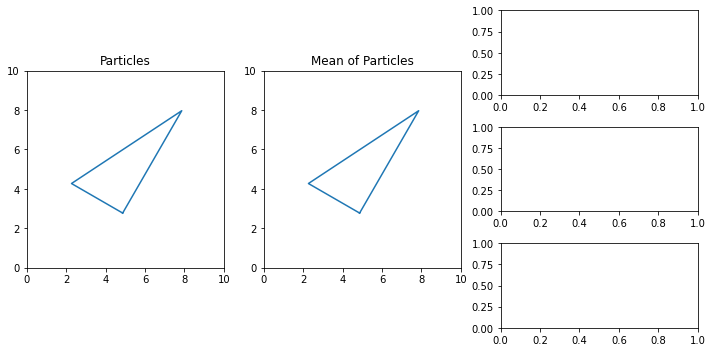

In [2]:
# World
# shape = Polygon([[0, 0], [6, 0], [6, 1],[0, 1], [0, 0]]) # rectangle
shape = Polygon([[0, 0], [6, 0], [0, 3], [0, 0]]) # triangle
# Center shape
shape
x = 5
y = 5
theta = np.pi/3
map_size = 10, 10

# ParticleFilter
num_particles = 1000

# Experiment
lookahead_depth = 0 ########################################################################## important shit right here
discount = 0.9

action_controller = ActionController(
    shape, x, y, theta, map_size, 
    num_particles, 
    lookahead_depth, discount, 
)

# Simulation
max_iterations = 1000
entropies = []
total_iterations = 1

# Stopping criteria
# Mean thresholds
mean_xy_dif = 1
mean_theta_dif = np.pi/8
# Standard deviation thresholds
std_xy_threshold = 2
std_theta_threshold = np.pi/8


# Visuals

fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(nrows=3, ncols=3)

ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[:,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,2])
ax5 = fig.add_subplot(gs[2,2])

action_controller.world.plot(ax1)
action_controller.world.plot(ax2)
ax1.set_title('Particles')
ax2.set_title('Mean of Particles')
fig.tight_layout()

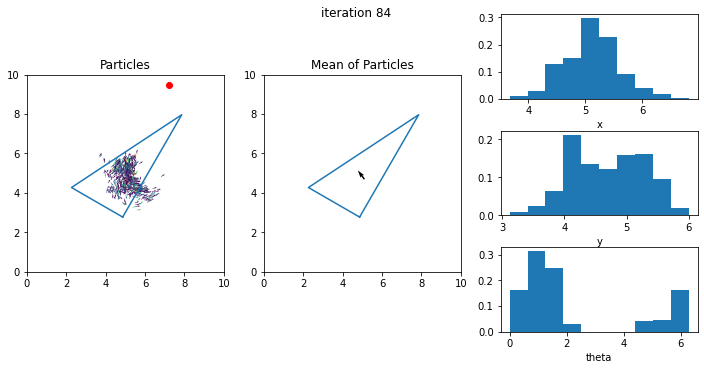

In [ ]:
%%time
# %%capture cap

# Run
iteration = 0
start_time = time.perf_counter()
while not action_controller.converged:
    iteration += 1
    action_controller.tick()
    
    # Visuals
    
    s = ax1.scatter(*action_controller.previous_action, c='r')
    q = action_controller.particle_filter.draw_particles(ax1)
    ax3.clear(); ax4.clear(); ax5.clear();
    h1, h2, h3 = action_controller.particle_filter.draw_histogram(ax3, ax4, ax5)

    x,y,t = action_controller.particle_filter.get_state() # access estimated state
    q2 = ax2.quiver(x, y, np.cos(t), np.sin(t), label='Estimate')
    display.display(fig)
    display.clear_output(wait=True)
    
    fig.suptitle(f"iteration {iteration}")
    fig.savefig(f"SDM sim - 3.6.2021 - lookahead_depth={lookahead_depth}/iteration={iteration}.png", format='png')
    
    s.remove()
    q.remove()
    q2.remove()
    
    if iteration == max_iterations:
        break

end_time = time.perf_counter()
duration = end_time - start_time

np.save(f"SDM sim entropies - 3.7.2021 - lookahead_depth={lookahead_depth}, duration={duration:.2f} sec.npy", np.array(action_controller.entropies))
np.save(f"SDM sim costs - 3.7.2021 - lookahead_depth={lookahead_depth}, duration={duration:.2f} sec.npy", np.array(action_controller.costs))


### Make figures

In [3]:
lookahead_depth = 0
gif_path = f"SDM gif - 3.7.2021 - lookahead_depth={lookahead_depth}.gif"
image_dir = Path(f"SDM sim - 3.7.2021 - lookahead_depth={lookahead_depth}")
with imageio.get_writer(gif_path, mode='I') as writer:
    for image_path in image_dir.iterdir():
        writer.append_data(imageio.imread(image_path))


FileNotFoundError: The gifsicle library was not found on your system.
On MacOS it is automatically installed using brew when you use the pip install command.
On other systems, like Linux systems and Windows, it prompts the instructions to be followed for completing the installation.
You can learn more on how to install gifsicle on the gifsicle and pygifsicle documentation.

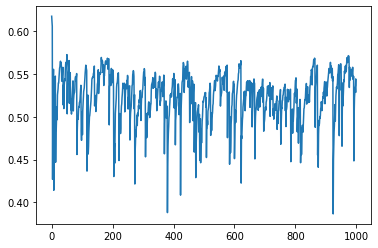

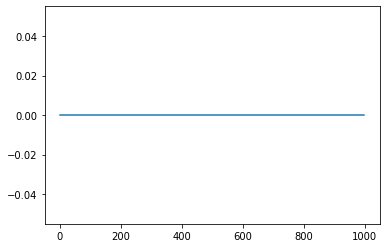

In [4]:
entropies_lookahead_depth_0 = np.load("SDM sim entropies - 3.6.2021 - lookahead_depth=0, duration=1228.91 sec.npy")
costs_lookahead_depth_0 = np.load("SDM sim costs - 3.6.2021 - lookahead_depth=0, duration=1228.91 sec.npy")

plt.plot(entropies_lookahead_depth_0)
plt.show()
plt.plot(costs_lookahead_depth_0)

# Tim's work below

In [1]:
# particle_filter_example.ipynb
# February 16, 2021
# Tim Player playert@oregonstate.edu

In [3]:
from shapely.geometry import Point, Polygon
from StateEstimator import ParticleFilter
from World import World
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from IPython import display
import time

### Define a 2D World containing an object.

In [4]:
# Define the shape, location, and angle of the object.
shape = Polygon([[0, 0], [6, 0], [6, 1],[0, 1], [0, 0]])
x = 1
y = 1
theta = np.pi/6

# Create a World object to store the map and do measurements.
map_size = (10,10) 
w = World(shape, x, y, theta, map_size)

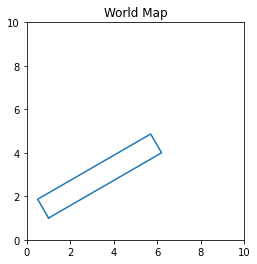

In [5]:
fig, ax = plt.subplots()
w.plot(ax)

### Run particle filter, measuring randomly

KeyboardInterrupt: 

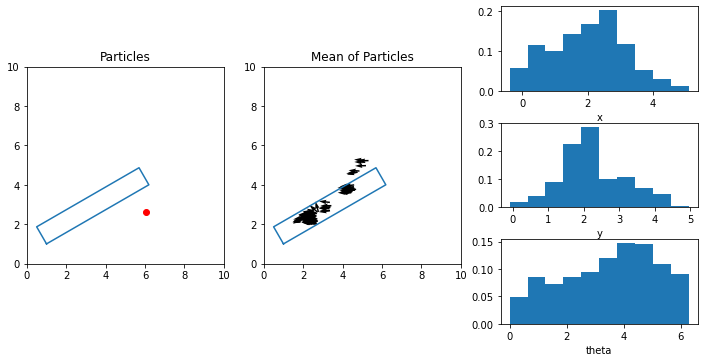

In [7]:
# Make a particle  filter
n = 500 # run for n steps.
pf = ParticleFilter(shape, 1000, map_size)

# Set up two plots
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(nrows=3, ncols=3)

ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[:,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,2])
ax5 = fig.add_subplot(gs[2,2])

w.plot(ax1)
w.plot(ax2)
ax1.set_title('Particles')
ax2.set_title('Mean of Particles')
fig.tight_layout()

rand_entropies = []
# Repeatedly update the particle filter, measuring randomly.
for i in range(n):
    # select random measurement
    x = np.random.uniform(0,map_size[0])
    y = np.random.uniform(0,map_size[1])
    
    # update particle filter with measurement
    z = w.measure(x, y)
    pf.update(z)
    rand_entropies.append(pf.get_entropy())
    
    # Plot
    s = ax1.scatter(z[0], z[1], c='r')
    q = pf.draw_particles(ax1)
    ax3.clear(); ax4.clear(); ax5.clear();
    h1, h2, h3 = pf.draw_histogram(ax3, ax4, ax5)
    
    x,y,t = pf.get_state() # access estimated state
    q2 = ax2.quiver(x, y, np.cos(t), np.sin(t), label='Estimate')
    display.display(fig)
    display.clear_output(wait=True)
    if i != n-1:
        q.remove()
        s.remove()

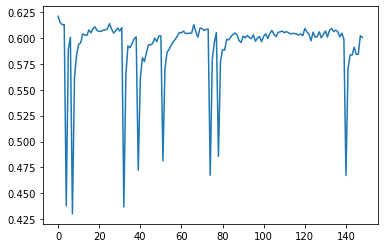

In [8]:
plt.plot(rand_entropies)

### Run particle filter, prompting user for input

X,Y coordinate to measure: 2,2


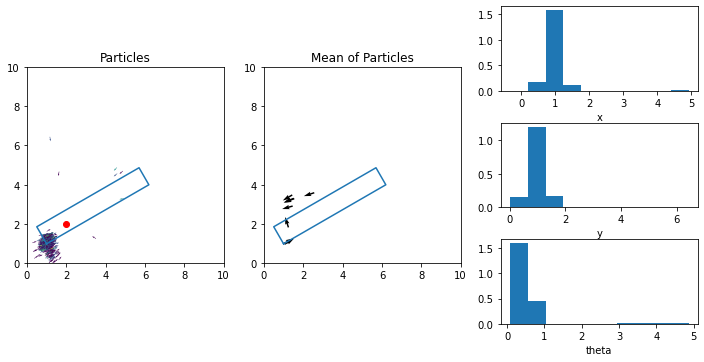

In [ ]:
# Make a particle  filter
pf = ParticleFilter(shape, 1000, map_size)

# Set up two plots
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(nrows=3, ncols=3)

ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[:,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,2])
ax5 = fig.add_subplot(gs[2,2])

w.plot(ax1)
w.plot(ax2)
ax1.set_title('Particles')
ax2.set_title('Mean of Particles')
fig.tight_layout()

# Repeatedly update the particle filter, measuring at user-defined locations.
while(True):
    # select random measurement
    try:
        x,y = tuple(float(x.strip()) for x in input("X,Y coordinate to measure:").split(','))
    except ValueError as e:
        print(e)
        continue
        
    # update particle filter with measurement
    z = w.measure(x, y)
    pf.update(z)
    
    # Plot
    s = ax1.scatter(z[0], z[1], c='r')
    q = pf.draw_particles(ax1)
    ax3.clear(); ax4.clear(); ax5.clear();
    h1, h2, h3 = pf.draw_histogram(ax3, ax4, ax5)
    
    x,y,t = pf.get_state() # access estimated state
    q2 = ax2.quiver(x, y, np.cos(t), np.sin(t), label='Estimate')
    display.display(fig)
    display.clear_output(wait=True)

    q.remove()
    s.remove()